### Problem description


### Mixed effects model  - Varying Intercepts

In fixed effect model coefficients of a linear model are the same for all samples. Variance is explained by ${\epsilon}_{i}$, which is assumed to be iid and ${\epsilon}_{i} = \mathcal N(0,{\sigma}_{\epsilon})$.

Likelihood 

\begin{equation}
{Wake}_{i} = {\beta}_{0} + {u}_{0} + {\beta}_{1}{Treatment}_{i} + {\beta}_{2}{Genotype}_{i} + {\epsilon}_{i}
\end{equation}

or alternatively

\begin{equation}
{Wake}_{i} = \mathcal N({\mu}_{i},{\sigma}_{\epsilon})\\
{\mu}_{i} = {\beta}_{0} + {u}_{0} + {\beta}_{1}{Treatment}_{i} + {\beta}_{2}{Genotype}_{i}\\
{\sigma}_{\epsilon} \sim Uniform(0,\infty)\\
{\sigma}_{u} \sim Uniform(0,\infty)
\end{equation}

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

In [169]:
data = pd.read_csv("data.csv")
data.head(10)

,id,NREM,REM,WAKE,Genotype,Treatment
0,16,36.172007,5.185497,58.642496,1,1
1,12,33.702835,3.837135,62.460030,0,1
2,4,57.606145,3.520376,38.873480,1,0
3,3,50.582650,8.955546,40.461804,0,0
4,11,35.646347,3.415478,60.938176,0,1
5,14,57.264584,11.426699,31.308718,0,0
6,5,33.987216,5.378003,60.634781,1,1
7,6,53.799880,8.602366,37.597754,0,0
8,8,46.321746,5.557801,48.120453,0,1
9,15,36.586851,3.530844,59.882305,0,1


In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         33 non-null     int64  
 1   NREM       33 non-null     float64
 2   REM        33 non-null     float64
 3   WAKE       33 non-null     float64
 4   Genotype   33 non-null     int64  
 5   Treatment  33 non-null     int64  
dtypes: float64(3), int64(3)
memory usage: 1.7 KB


In [173]:
data_dict = data.to_dict()

N         = data.shape[0]
J         = len(set(data['id']))
subjid    = list(data_dict['id'].values())
treatment = list(data_dict['Treatment'].values())
genotype  = list(data_dict['Genotype'].values())
wake      = list(data_dict['WAKE'].values())

stan_data = {"N": N,
             "J": J,
             "y": wake,
             "id": subjid,
             "treat": treatment,
             "gen": genotype
            }

In [174]:
import nest_asyncio
nest_asyncio.apply()
import stan

stan_code = """
data {
  int<lower=0> N;                         // n.o. samples
  int<lower=0> J;                         // n.o. subj
  real y[N];                              // measurments, response var
  int id[N];                              // subject id
  int<lower=0,upper=1> gen[N];            // predictor genotype
  int<lower=0,upper=2> treat[N];          // predictor treatment
}

parameters {
  real<lower=0> sigma;    // sheared standard deviation 
  vector[3] beta;         //fixed intercept and slopes
  
  real<lower=0> sigma_u;  //subj sd
  vector[J] u;            //subj intercepts
}

model {
  //priors
  u ~ normal(0,sigma_u);     //subj intercepts
  beta ~ normal(0,100);
  
  real mu;
  for (i in 1:N){
      mu = beta[1] + u[id[i]] + beta[2]*treat[i] + beta[3]*gen[i];
      y[i] ~ normal(mu, sigma);
      }
}

generated quantities {
    real ypred[N];
    real mu;
    
    for (i in 1:N){
      mu = beta[1] + u[id[i]] + beta[2]*treat[i] + beta[3]*gen[i];
      ypred[i] = normal_rng(mu, sigma);
      }
}

"""

posterior = stan.build(stan_code, data=stan_data)
fit = posterior.sample(num_chains=4, num_samples=4000)
df = fit.to_frame()

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.5s
Building: 3.6s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:6:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:33:8: warning: unused variable 'error' [-Wunused-variable]
  bool error = false;
       ^
/Users/shamsi/anacon

Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/err.hpp:50:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/err/hmm_check.h

Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun/be

Building: 5.2s
Building: 5.3s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun.hpp:54:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include

Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun.hpp:121:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun/matrix_power.hpp:52:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'const int' [-Wsign-compare]
  for (size_t i = 2; i <= n; ++i) {
                     ~ ^  ~
In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddta

Building: 6.9s
Building: 7.0s
Building: 7.2s
Building: 7.3s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun.hpp:153:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp:40:30: warning: comparison of integers of different signs: 'Eigen::Index' (aka 'long') and 'size_t' (aka 'unsigned long') [-Wsign-compare]
  for (Eigen::Index k = 0; k < N; ++k) {
                           ~ ^ ~
/Users/shamsi/anaconda3/envs/dlaalto/lib/python

Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:11:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/functor.hpp:28:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/functor/operands_and_partials.hpp:29:1: warning: 'ops_partials_edge' defined as a class template here but previously declared as a struct template; this is valid, but may result in linker errors under the Microsoft C++ ABI [-Wmismatched-tags]
class ops_partials_edge<double, var> {
^

Building: 10.7s
Building: 10.8s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/prob.hpp:87:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/prob/double_exponential_cdf.hpp:77:10: warning: unused variable 'N' [-Wunused-variable]
  size_t N = max_size(y, mu, sigma);
         ^
In file included from

Building: 10.9s
Building: 11.1s
Building: 11.2s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/prob.hpp:139:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/prob/hmm_marginal.hpp:26:13: warning: unused variable 'n_states' [-Wunused-variable]
  const int n_states = omegas.rows();
            ^


Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 12.0s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/prob.hpp:307:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/ma

Building: 12.1s
Building: 12.2s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:7:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<double, std::__1::allocator<double> >::size_type' (aka 'unsigned long') [-Wsign-compare]
      for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
                                         ~~~~~~~~~ ^ ~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int, std::__1::allocator<int> >::size_type' (aka 'unsigned long') [-Wsign-compare]
             real_iter < val_i->second.first.size();
 

Building: 12.3s
Building: 12.4s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:17:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/indexing.hpp:6:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/indexing/assign.hpp:270:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int, std::__1::allocator<int> >::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/indexing/assign.hpp:538:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int, std::__1::allocator<int> >::size_type' (aka 'unsigned lon

Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.9s
Building: 13.0s
Building: 13.1s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core.hpp:29:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core/operator_divide_equal.hpp:5:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core/operator_division.hpp:14:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/

Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/mat

Building: 14.3s
Building: 14.5s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/mat

Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math

Building: 15.3s
Building: 15.4s
Building: 15.6s
Building: 15.7s
Building: 15.8s


In file included from /Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.cpp:2:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core.hpp:58:
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/include/stan/math/rev/core/set_zero_all_adjoints.hpp:14:13: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
static void set_zero_all_adjoints() {
            ^
In file included from /Users/shamsi/Library/Caches/ht

Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.8s
Building

56 warnings generated.


ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-10.9-x86_64-3.7/Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddtaxna/model_dddtaxna.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-10.9-x86_64-3.7/Users/shamsi/Library/Caches/httpstan/4.6.1/models/dddta

Messages from stanc:
Warning in '/var/folders/z0/1gmwp03s4lnc5_dw7cgfx0cw0000gn/T/httpstan_9wz85b3e/model_dddtaxna.stan', line 22, column 18: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:  25% (5000/20000)
Sampling:  50% (10000/20000)
Sampling:  75% (15000/20000)
Sampling: 100% (20000/20000)
Sampling: 100% (20000/20000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/fo

In [175]:
az.summary(fit)[:100]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,7.425,1.118,5.476,9.552,0.017,0.012,4754.0,6453.0,1.00
beta[0],42.453,2.507,37.599,46.985,0.035,0.025,5157.0,5670.0,1.00
beta[1],15.059,1.629,12.053,18.199,0.023,0.016,5206.0,5164.0,1.00
beta[2],-0.380,2.893,-5.863,5.071,0.036,0.025,6630.0,8312.0,1.00
sigma_u,2.520,1.628,0.142,5.435,0.064,0.045,396.0,308.0,1.01
u[0],-0.341,2.428,-5.359,4.277,0.019,0.032,17180.0,7526.0,1.00
u[1],0.171,2.571,-4.724,5.538,0.019,0.032,19607.0,6499.0,1.00
u[2],0.490,2.394,-3.967,5.611,0.022,0.032,15227.0,6122.0,1.00
u[3],-1.586,2.834,-7.589,3.028,0.052,0.037,3531.0,5791.0,1.00
u[4],0.675,2.434,-3.771,6.010,0.022,0.030,14677.0,6659.0,1.00


In [176]:
print(df.describe().T[:15])

                 count        mean        std           min         25%  \
parameters                                                                
lp__           16000.0 -101.036391  13.234846 -1.409767e+02 -110.550098   
accept_stat__  16000.0    0.913889   0.183648  1.428415e-15    0.927241   
stepsize__     16000.0    0.128850   0.067947  2.292223e-02    0.093916   
treedepth__    16000.0    4.992000   1.529896  2.000000e+00    4.000000   
n_leapfrog__   16000.0   64.702375  87.320391  3.000000e+00   15.000000   
divergent__    16000.0    0.000000   0.000000  0.000000e+00    0.000000   
energy__       16000.0  113.051155  13.689780  3.981856e+01  105.330280   
sigma          16000.0    7.424834   1.118051  4.445928e+00    6.644539   
beta.1         16000.0   42.452842   2.507432  3.067527e+01   40.810206   
beta.2         16000.0   15.059182   1.628517  7.852593e+00   13.985123   
beta.3         16000.0   -0.379834   2.893373 -1.287130e+01   -2.287559   
sigma_u        16000.0   

In [1]:
intercept = df["beta.1"].mean()
coeff1 = df["beta.2"].mean()
coeff2 = df["beta.3"].mean()

treat = [0, 1, 2]
genotype = [0, 1]

def jitter(vals):
    return vals + np.random.normal(0,0.05,vals.shape)

ypred = []
for i in range(len(genotype)):
    for j in range(len(treat)):
        ypred.append(intercept + coeff1*treat[j] + coeff2*genotype[i])
    
sns.scatterplot(data=data, x=jitter(data["Treatment"]), y="WAKE", hue="Genotype")
sns.lineplot(x=[0,1,2], y=ypred[:3])
sns.lineplot(x=[0,1,2], y=ypred[3:])
plt.show()

NameError: name 'df' is not defined

<AxesSubplot:>

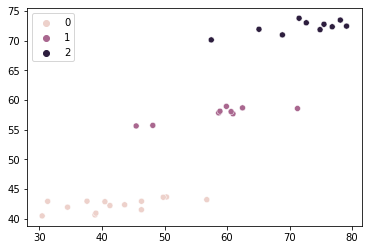

In [178]:
sns.scatterplot(x=wake, y=list(ypreds.mean()), hue=treatment)

<AxesSubplot:ylabel='Density'>

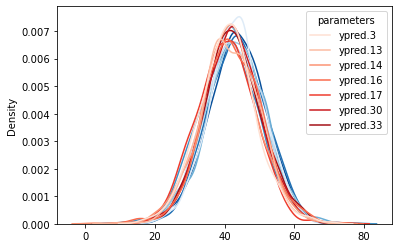

In [181]:
ypreds = df.iloc[-1000:,31:-1].copy()

sns.kdeplot(data = ypreds.iloc[:,wtsal], palette="Blues")
sns.kdeplot(data = ypreds.iloc[:,kosal], palette="Reds")
# sns.kdeplot(data = ypreds.iloc[:,wt3], palette="Reds")
# sns.kdeplot(data = ypreds.iloc[:,wt10], palette="Greens")

In [125]:
data[(data["Genotype"]==0) & (data["Treatment"]==0)]

,id,NREM,REM,WAKE,Genotype,Treatment
3,3,50.582650,8.955546,40.461804,0,0
5,14,57.264584,11.426699,31.308718,0,0
7,6,53.799880,8.602366,37.597754,0,0
19,14,42.585377,0.664680,56.749943,0,0
22,8,55.463138,5.519849,39.017013,0,0
23,15,47.309762,2.382782,50.307456,0,0
25,10,46.991460,3.222050,49.786491,0,0


In [180]:
wtsal = data.index[(data["Genotype"]==0) & (data["Treatment"]==0)]
wt3   = data.index[(data["Genotype"]==0) & (data["Treatment"]==1)]
wt10  = data.index[(data["Genotype"]==0) & (data["Treatment"]==2)]

kosal = data.index[(data["Genotype"]==1) & (data["Treatment"]==0)]
ko3   = data.index[(data["Genotype"]==1) & (data["Treatment"]==1)]
ko10  = data.index[(data["Genotype"]==1) & (data["Treatment"]==2)]